## Ingestão de dados

In [0]:
# Importação do SparkSession
from pyspark.sql import SparkSession

#Criando uma sessão Spark
spark = SparkSession.builder.appName("AnaliseVendas").getOrCreate()

caminho_arquivo = "default.online_retail"

df_vendas = spark.read.table(caminho_arquivo)
df_vendas.printSchema()
df_vendas.show(5)


root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6

## Limpeza dos dados

In [0]:
from pyspark.sql import functions as F

print("--- DataFrame Origial ---")
print(f"Numero de linhas originais: {df_vendas.count()}")

# 1. Tratar os valores nulos na coluna de ID
df_limpo = df_vendas.na.drop(subset=["CustomerID"])

# 2. Corrigir a data de String para TimeStamp (análises temporais)
df_limpo = df_limpo.withColumn("InvoiceDate", F.to_timestamp(F.col("InvoiceDate"), "M/d/yyyy H:mm"))

# 3. Filtrar dados inválidos (valores negativos em Quantity e UnitPrice)
df_limpo = df_limpo.filter((F.col("Quantity") > 0) & (F.col("UnitPrice") > 0))

# 4. Remover linhas duplicadas
df_limpo = df_limpo.dropDuplicates()

print("--- DataFrame Limpo ---")
print(f"Numero de linhas limpas: {df_limpo.count()}")
df_limpo.printSchema()
df_limpo.show(5)



--- DataFrame Origial ---
Numero de linhas originais: 541909
--- DataFrame Limpo ---
Numero de linhas limpas: 392692
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- Country: string (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|2010-12-01 08:26:00|     3.39|     17850|United Kingdom|
|   5363

In [0]:
# Análise da porcentagem de linhas removidas
x = 541909
y = 392692
print(f"Porcentagem de linhas removidas: {round((x-y)/x*100,2)}%")

Porcentagem de linhas removidas: 27.54%


## Transformação dos dados

In [0]:
# -- 1. Criando novas colunas --

# a. Adicionando coluna de preço total e extraindo o ano e mês da coluna data
df_transformado = (df_limpo
    .withColumn("TotalPrice", F.col("Quantity") * F.col("UnitPrice"))
    .withColumn("Year", F.year(F.col("InvoiceDate")))
    .withColumn("Month", F.month(F.col("InvoiceDate")))
)

print("--- Dataframe após transfomação ---")
df_transformado.printSchema()
df_transformado.show(5)

# -- 2. Agregação para Análise ---

# a. Calculando a receita total por produto
df_total_produto =  (
    df_transformado
    .groupBy("Description")
    .agg(F.sum("TotalPrice").alias("TotalRevenue"))
)

# b. Encontrando os 10 produtos mais vendidos
print("\n --- Top 10 produtos mais vendidos ---")
df_total_produto.orderBy(F.col("TotalRevenue").desc()).show(10, truncate=False)

# c. Calculando a receita total por mês
df_total_mes = df_transformado.groupBy("Year","Month"). agg(F.sum("TotalPrice").alias("MonthlyRevenue"))

print("\n --- Receita total por mês ---")
df_total_mes.orderBy("Year","Month").show()

--- Dataframe após transfomação ---
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+----+-----+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|        TotalPrice|Year|Month|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------------------+----+-----+
|   536365|   85123A|WHITE HANGING HEA...|       6|2010-12-01 08:26:00|     2.55|     17850|United

## Visualização

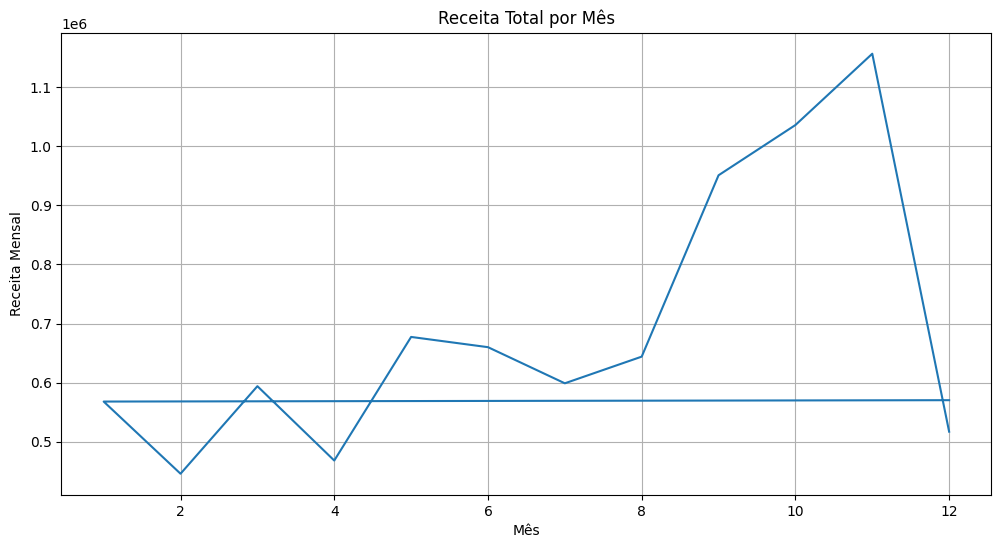

In [0]:
import matplotlib.pyplot as plt

# Converter o Spark DataFrame para um Pandas DataFrame (apenas para visualização local)
df_total_mes_pandas = df_total_mes.toPandas()

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_total_mes_pandas["Month"], df_total_mes_pandas["MonthlyRevenue"])
plt.title("Receita Total por Mês")
plt.xlabel("Mês")
plt.ylabel("Receita Mensal")
plt.grid(True)
plt.show()

## Análise

-> Com a criação do gráfico é possivel ver que existe uma forte sazonalidade nas vendas, a receita flutua bastante ao longo do ano, com um crescimento notável no segundo semestre.

-> Ocorre um forte pico de vendas no mês 11, isso evidência que a empresa se beneficia de eventos de fim de ano como a Black Friday, que costuma ocorrer em Novembro.

-> Queda pós-pico, em Dezembro ocorre uma queda abrupta, sendo um ponto de partida para futuras explorações.

-> Existe uma janela de foco do Marketing nos meses de baixo desempenho e a necessidade de otimizar as operações para atender a alta demanda nos meses 10 e 11.